# Reflective Error - Part I

## Introduction
This notebook reproduces the first set of experiments, the synthetic or "toy" problems, in the Environmental Data Science paper "Reflective Error: A Metric for Assessing Predictive Performance at Extreme Events" and is designed to provide a step by step guide on the rationale for the metric and the associated loss function.  As explained in the paper, the metric and loss function are designed to give a generalisable quantification of model error with respect to the underlying probability distribution that best fits the data.

To get started, we'll import all of the prerequisite libraries, including numpy, pandas, scipy, and matplotlib, and we'll also set some global parameters for graph presentation, random number seeds for reproducability.

In [29]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk

plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'
fontlibrary = str('font.' + 'serif')
plt.rcParams[fontlibrary] = ['Times New Roman']

np.random.seed(42)

The metrics that we'll be using in this notebook are Root Mean Squared Error (RMSE), R$^2$, and Reflective Error (RE), as laid out below in terms of observations, $y$, and predictions, $y'$.  For RE, $\Psi_{\phi}(y_i)$ is the weighting to be applied to the error at any given $y$ based on the underlying, probability distribution corresponding to values $y$ within the local subdomain, $\phi$, of the target domain, $Y$.  Note that for the stationary form of RE, $\phi = Y$.  The scaling factor $\kappa = \underset{y}{\max} \big(U(y)\big)$ and $\alpha$ and $\beta$ are parameters set to $1$ for the metric and hyperparameters to be tuned by the user for the reflective loss function.

$$
RMSE = \sqrt{\frac{\sum_{i=1}^{n}(y_i - y_i')^2}{n}}
$$

$$
R^2 = 1 - \Bigg( \frac{\sum_{i=1}^{n}(y_i - y_i')^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2} \Bigg)
$$

$$
\Psi(y) = - \alpha \cdot \frac{U(y)}{\kappa} + \beta
$$

$$
RE = \Bigg( \frac{\sum_{i=1}^{n}(y_i - y_i')^2\cdot \Psi_{\phi}(y_i)}{\sum_{i=1}^{n}(y_i - y_i')^2} \Bigg) ^{\frac{1}{2}}
$$

In [51]:
def RMSE(y_o, y_p):
    '''
    Function to evalate the root mean squared error
    between a set of observations and predictions
    
    Parameters
    ----------
    y_o : Float, Numpy Array, or Pandas DataFrame Column
        Set of observations, y
    y_p : Float, Numpy Array, or Pandas DataFrame Column
        Set of predictions, y'
        
    Returns
    -------
    rmse : Float
        Root Mean Squared Error
    '''
    total = (((y_o - y_p)**2)/len(y_o))
    rmse = sum(total)**0.5
    return rmse


def R2(y_o, y_p):
    '''
    Function to evalate the r2 value between
    a set of observations and predictions
    
    Parameters
    ----------
    y_o : Float, Numpy Array, or Pandas DataFrame Column
        Set of observations, y
    y_p : Float, Numpy Array, or Pandas DataFrame Column
        Set of predictions, y'
        
    Returns
    -------
    r2 : Float 
        R2
    '''
    cache1 = ((y_o - y_p)**2)
    mu = np.mean(y_o)
    cache2 = ((y_o - mu)**2)
    r2 = 1 - (sum(cache1))/(sum(cache2))
    return r2

def PSI(u_of_y, kappa, alpha=1, beta=1):
    '''
    Function to evalate the weighting to be applied
    elementwise to error terms with 

    Parameters
    ----------
    u_of_y : Float, Numpy Array, or Pandas DataFrame Column
        Probability of y, elementwise, according to
        the distribution fitted to training data
    alpha : Float
        Reflective scaling hyperparameter.
    beta : Float
        Reflective shift hyperparameter.
    kappa : Float
        Global maximum of u_of_y (recommend using calculus to find).

    Returns
    -------
    psi : Float, Numpy Array, or Pandas DataFrame Column
        Reflective weighting to be applied in the loss
        function during network training.

    '''
    psi  = -1 * alpha * (u_of_y/kappa) + beta
    return psi


def RE(y_o, y_p, psi):
    '''
    Function to evalate the reflective error
    between a set of observations and predictions
    
    Parameters
    ----------
    y_o : Float, Numpy Array, or Pandas DataFrame Column
        Set of observations, y
    y_p : Float, Numpy Array, or Pandas DataFrame Column
        Set of predictions, y'
        
    Returns
    -------
    r_rmse : Float
        Reflective Root Mean Squared Error
    '''
    cache1 = ((y_o - y_p)**2)
    re = ((sum(cache1 * psi))/(sum(cache1)))**(0.5)
    return re

## A Stationary & Gaussian Synthetic Example
The first experiment in the paper uses a normally distributed dataset $X \sim \mathcal{N}(3.5, 0.75^2)$ of 500 data points that we arrange in ascending order as our observations; our predictive 'model' is the same data with the addition of some Gaussian noise term $\epsilon_{1} \sim \mathcal{N}(0, 0.1^2)$.  We'll then create a pair of error scenarios, adding some randomly generated error, $\epsilon_{2} \sim \mathcal{N}(0, 1.0^2)$: a routine error scenario, where this error is added to the 100 data points closest to the mean; and an extreme error scenario, where this error is added to the 100 data points furthest from the mean, in either direction.

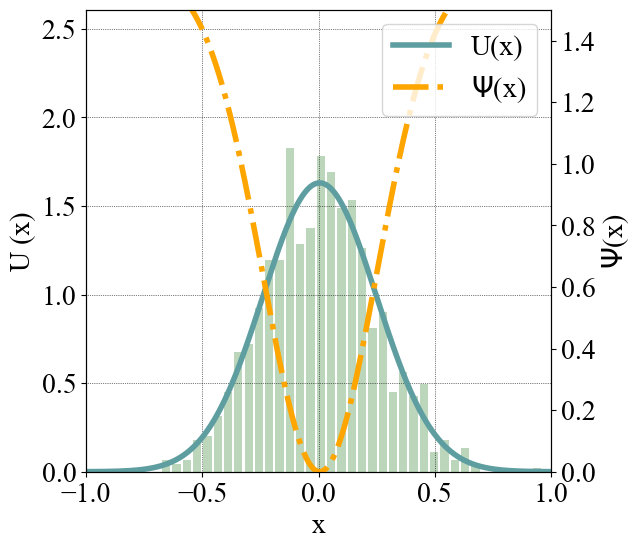

- - - - - - - - - - - - - - -
Model vs. Unperturbed Data
- - - - -
RMSE: 0.19672832109518917
R2: 0.932449879619045
RE: 0.8014003867334712
- - - - - - - - - - - - - - -


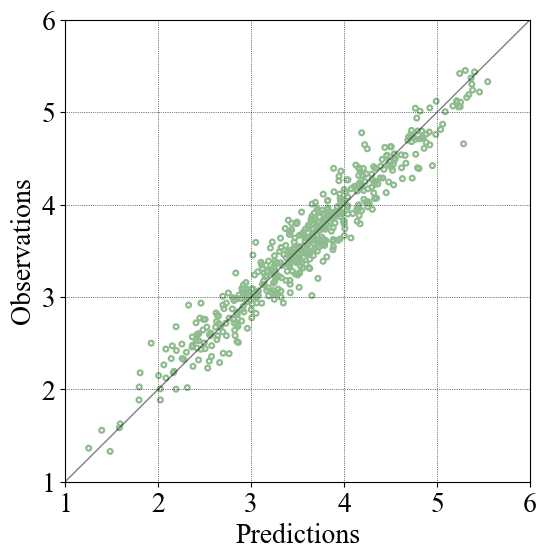

- - - - - - - - - - - - - - -
Model vs. Extremity Perturbed Data
- - - - -
RMSE: 0.485922485199729
R2: 0.5878774792812014
RE: 0.9648520203600283
- - - - - - - - - - - - - - -


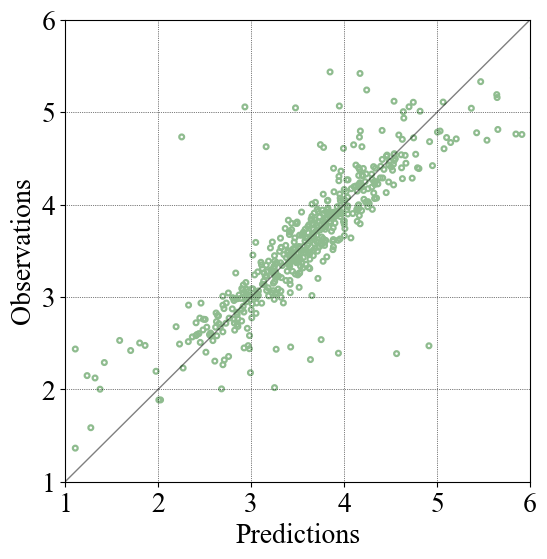

- - - - - - - - - - - - - - -
Model vs. Centrally Perturbed Data
- - - - -
RMSE: 0.4715953309290225
R2: 0.6118216145185476
RE: 0.41486042466031936
- - - - - - - - - - - - - - -


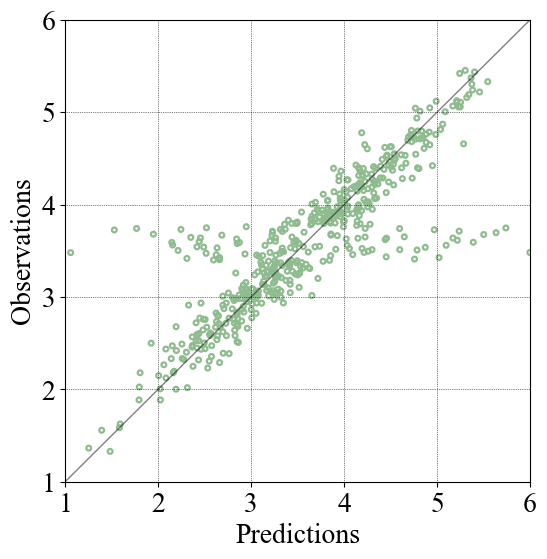

In [39]:
### Gaussian distribution class
class Gaussian_Data_Model():
    def __init__(self, name, x, mu, sigma):
        '''
        Initialises an instance of a Gaussian model where parameters are fitted
        to a dataset resampled from a given dataset in order to conduct
        comparative analysis.

        Parameters
        ----------
        name : String
            Name of model or scenario.
        x : Array
            Initial array of values.
        mu : Float
            Gaussian distribution mean.
        sigma : Float
            Gaussian distribution standard deviation.

        Returns
        -------
        None.
        '''
        self.name = str(name)
        self.x = x
        self.mu = mu
        self.sigma = sigma
        self.sample = np.sort(np.random.normal(self.mu, self.sigma, len(self.x)))
        self.mu_o, self.sigma_o = sp.stats.norm.fit(self.sample)
        self.kappa = 1/(self.sigma_o * np.sqrt(2*np.pi))
    
    def u_of_x(self, x):
        '''
        Calculates the probabilities for corresponding x values.

        Parameters
        ----------
        x : Array
            Input array.

        Returns
        -------
        u : Array
            Probability density array.
        '''
        u = 1/(self.sigma_o*np.sqrt(2*np.pi)) * \
                    np.exp(-(x-self.mu_o)**2/(2 * self.sigma_o**2))
        return u

    def histPlot(self, s=6):
        '''
        Generates a histogram for an input dataset with the pdf shown on the
        left axis and the reflective weighting shown on the right axis.

        Parameters
        ----------
        s : Float, optional
            Size for the plot. The default is 6.

        Returns
        -------
        The histogram plot outputted to the viewport.
        '''
        fig, ax1 = plt.subplots(figsize=(s, s))
        count, bins, ignored = plt.hist(self.sample, int(np.round(len(self.x)/25)), 
                                        density=True,rwidth=0.8,
                                        color='darkseagreen', alpha=0.6)
        ax1.plot(self.x, self.u_of_x(self.x), 'cadetblue', lw=4, 
                 ls='-', label='U(x)')
        ax1.set_xlim(self.x.min(), self.x.max())
        ax1.set_xlabel('x')
        ax1.set_ylim(0, np.round(self.u_of_x(self.x).max(), 2)/0.625)
        ax1.set_ylabel('U'+' (x)')
        ax1.grid(c='black', ls='dotted', lw=0.5)
        ax2 = ax1.twinx()
        ax2.plot(self.x, PSI(self.u_of_x(self.x), 1, 1, self.kappa),
                 'orange', lw=4, ls='-.', label=r'$\Psi$(x)')
        ax2.set_ylim(0, 1.5)
        ax2.set_ylabel(r'$\Psi$(x)')
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        plt.show()
    
    def report_error(self, scenario, data):
        '''
        Generates error metrics between the class data and another set of data,
        including root mean squared error, r^2, and reflective error.

        Parameters
        ----------
        other : Array
            The second set of data being compared against the class sample data.
        scenario : String
            The name of the second dataset being compared.

        Returns
        -------
        rmse : Float
            Root mean squared error.
        r2 : Float
            R2 score.
        re : Float
            Reflective Error score.
        '''
        rmse = RMSE(self.sample, data)
        r2 = R2(self.sample, data)
        re = RE(self.sample, data, PSI(self.u_of_x(self.x), self.kappa))
        print('- - - - - - - - - - - - - - -')
        print(self.name + ' vs. ' + scenario)
        print('- - - - -')
        print('RMSE: ' + str(rmse))
        print('R2: ' + str(r2))
        print('RE: ' + str(re))
        print('- - - - - - - - - - - - - - -')
        return rmse, r2, re
    
    def versus_plot(self, data, s=6):
        '''
        Generates a scatter plot of the class sample data plotted against a
        second dataset.

        Parameters
        ----------
        other : Array
            The second set of data being compared against the class sample data.
        s : Float, optional
            Size for the plot. The default is 6.

        Returns
        -------
        The scatter plot outputted to the viewport.
        '''
        xyline = np.linspace(self.x.min(), self.x.max())
        fig, ax = plt.subplots(figsize=(s, s))
        ax.scatter(data, self.sample, s=(s*2), edgecolors='darkseagreen',
                   lw=1.6, facecolors='none', marker = 'o')
        ax.plot(xyline, xyline, c='black', lw=1, alpha=0.5)
        ax.set_xlim(self.x.min(), self.x.max())
        ax.set_xlabel('Predictions')
        ax.set_ylim(self.x.min(), self.x.max())
        ax.set_ylabel('Observations')
        ax.grid(c='black', ls='dotted', lw=0.5)
        plt.show()


### Example relevance function for a Gaussian distribution
x1 = np.linspace(-1, 1, 1000)
g1 = Gaussian_Data_Model('Example', x1, 0, 0.25)
g1.histPlot()


### Setup observations
mu, sigma, n = 3.5, 0.75, 500
x_observations = np.linspace(1, 6, n)
y_observations = Gaussian_Data_Model('Model', x_observations, mu, sigma)
noise = np.random.normal(0, 0.2, len(x_observations))


### Unperturbed scenario
base_scenario = 'Unperturbed Data'
base_data = y_observations.sample + noise
_, _, _ = y_observations.report_error(base_scenario, base_data)
y_observations.versus_plot(base_data)


### Extreme perturbation scenario
extreme_scenario = 'Extremity Perturbed Data'
extreme_data = y_observations.sample + noise
extreme_data[:int(n/10)] += np.random.normal(0, 1.0, 50)
extreme_data[-int(n/10):] += np.random.normal(0, 1.0, 50)
_, _, _ = y_observations.report_error(extreme_scenario, extreme_data)
y_observations.versus_plot(extreme_data)


### Central perturbation scenario
central_scenario = 'Centrally Perturbed Data'
central_data = y_observations.sample + noise
central_data[int(n/2-n/10):int(n/2+n/10)] += np.random.normal(0, 1.0, 100)
_, _, _ = y_observations.report_error(central_scenario, central_data)
y_observations.versus_plot(central_data)

So we can already see that the standard error metrics, RMSE and R$^2$, for the different perturbed scenarios are similar but RE tells a different story, being closer to 1 for the extreme error scenario and closer to 0 for the routine error scenario.  We can now move on to the nonstationary experiment, highlighting how the metric can be tailored to data where there are changes in the mean over time, or with respect to some other dimension of interest.

## Nonstationary Reflective Error
As we've already stated, RE can be applied across subdomains.  In this example, we'll use a piecewise function as outlined below.

\begin{equation} \label{NSGauss}
    U(y) \sim
    \begin{cases}
        \mathcal{N}(0, 0.2^2) & \text{if } \; t_0\leq t < t_1\\
        \mathcal{N}(1, 0.2^2) & \text{if } \; t_1\leq t < t_2\\
        \mathcal{N}(-1, 0.2^2) & \text{if } \; t_2\leq t < t_3
    \end{cases}
\end{equation}

After creating the dataset that fits the above function, we'll then take a single 'observed' data point and move it to an extreme with our 'model prediction' failing to capture that extreme.  This will all be plotted with the observed anomaly highlighted.

/var/folders/l9/jsx2qx3x1qg1200t_my5rg880000gn/T/ipykernel_85212/4133292505.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['t'+r'$_{0}$',' ','t'+r'$_{1}$','t'+r'$_{2}$',
/var/folders/l9/jsx2qx3x1qg1200t_my5rg880000gn/T/ipykernel_85212/4133292505.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([-2,'',-1,'',0,'',1,'',2])


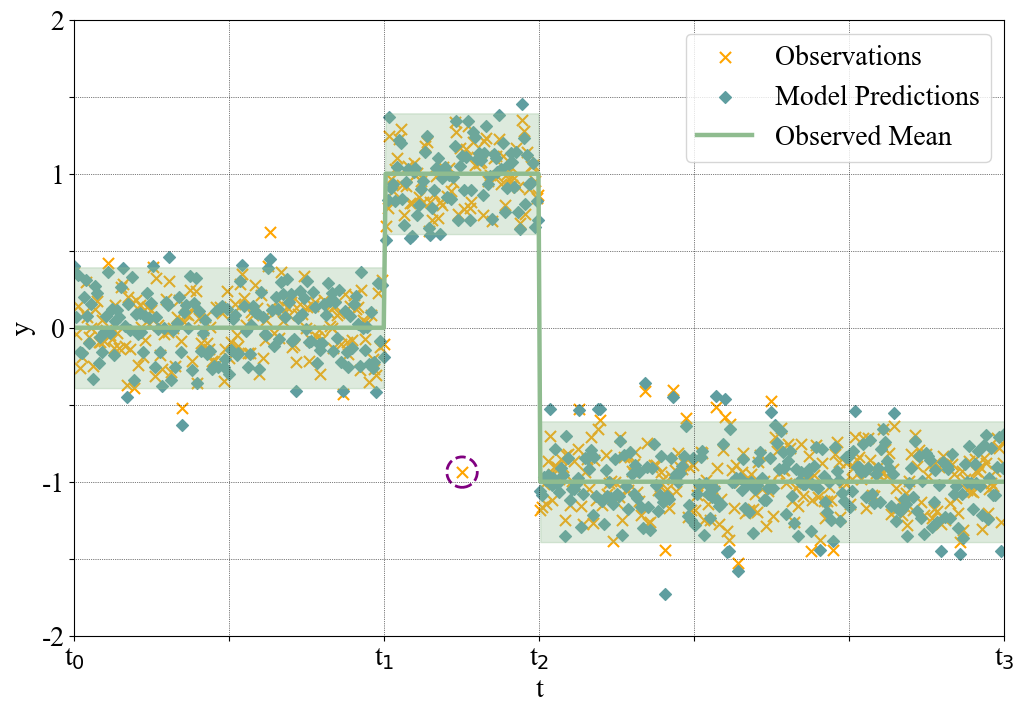

In [45]:
### Non stationary synthetic dataset
n = 500
sigma = 0.2
x_temporal = np.linspace(0, 6, n)
y_temporal = np.piecewise(x_temporal, [x_temporal<2, (x_temporal>=2) & (x_temporal<3), x_temporal>=3],
                    [lambda x: 0, lambda x: 1, lambda x: -1])
obs_temporal = y_temporal + np.random.normal(0, sigma, n)
prd_temporal = obs_temporal + np.random.normal(0, sigma/2, n)


### Shift one observation away to create a localised extreme
obs_temporal[208] = obs_temporal[208]-2.1
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x_temporal, obs_temporal, c='orange', marker = 'x',
           label='Observations', s=64)
ax.scatter(x_temporal, prd_temporal, c='cadetblue', marker = 'D',
           label='Model Predictions')
ax.scatter(x_temporal[208], obs_temporal[208], s=480, edgecolors='purple',
           lw=2, ls='--', facecolors='none', marker = 'o')
ax.plot(x_temporal, y_temporal, 'darkseagreen', lw=3.2, label='Observed Mean')
ax.fill_between(x_temporal,
                 y_temporal - 1.96 * sigma,
                 y_temporal + 1.96 * sigma,
                 color='darkseagreen', alpha=0.3)
ax.set_xlim(0, 6)
ax.set_xlabel('t')
ax.set_xticklabels(['t'+r'$_{0}$',' ','t'+r'$_{1}$','t'+r'$_{2}$',
                    ' ',' ','t'+r'$_{3}$'])
ax.set_ylim(-2, 2)
ax.set_ylabel('y')
ax.set_yticklabels([-2,'',-1,'',0,'',1,'',2])
ax.grid(c='black', ls='dotted', lw=0.5)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper right')
plt.show()

We'll calculate both the stationary and nonstationary RE values, using global $\Psi$ and windowed $\Psi$ values, and output both to show that the stationary form fails to identify the extreme misprediction whilst the nonstationary form does do so, subject to those the limits of those windows.

In [48]:
gaussians = [[0,0.2,(1/3)],
             [1,0.2,(1/6)],
             [-1,0.2,(1/2)]]
gmm_pdf = (sp.stats.norm.pdf(obs_temporal, gaussians[0][0], gaussians[0][1]) * gaussians[0][2] +
           sp.stats.norm.pdf(obs_temporal, gaussians[1][0], gaussians[1][1]) * gaussians[1][2] +
           sp.stats.norm.pdf(obs_temporal, gaussians[2][0], gaussians[2][1]) * gaussians[2][2])
psi_temporal = PSI(gmm_pdf, gaussians[2][2]*1/(gaussians[2][1] * np.sqrt(2*np.pi)))
print('Stationary RE: ' + str(RE(obs_temporal, prd_temporal, psi_temporal)))

obs_temporal[:167]
obs_temporal[167:250]
obs_temporal[250:]
psi_1 = (-1) * sp.stats.norm.pdf(obs_temporal[:167], gaussians[0][0], gaussians[0][1]) * (gaussians[0][1]* np.sqrt(2*np.pi)) + 1
psi_2 = (-1) * sp.stats.norm.pdf(obs_temporal[167:250], gaussians[1][0], gaussians[1][1]) * (gaussians[1][1]* np.sqrt(2*np.pi)) + 1
psi_3 = (-1) * sp.stats.norm.pdf(obs_temporal[250:], gaussians[2][0], gaussians[2][1]) * (gaussians[2][1]* np.sqrt(2*np.pi)) + 1
error_1 = ((obs_temporal[:167] - prd_temporal[:167])**2)
error_2 = ((obs_temporal[167:250] - prd_temporal[167:250])**2)
error_3 = ((obs_temporal[250:] - prd_temporal[250:])**2)
print('Nonstationary RE: ' + str(((sum(error_1 * psi_1) + sum(error_2 * psi_2) \
                                   + sum(error_3 * psi_3))/(sum((obs_temporal - prd_temporal)**2)))**(0.5)))

Stationary RE: 0.5267323252195458
Nonstationary RE: 0.786729285010725


The discrepancy between the two numbers, in that the Nonstationary RE > Stationary RE, shows that the nonstationary form of our metric is more sensitive to the added error being a local extreme.

The application of Reflective Error, both as a metric and as a loss function within neural models, to a real world example is conducted in the [Part II notebook](./reflective-error-part-II.ipynb).